# Craigslist Car Price Prediction

**Epistolary Acumen**

In this notebook we will build a model that predicts car price based on the seller description alone. NLP techniques we will take advantage of are Gensim's doc2vec and sentiment analysis in addition to part-of-speech tagging, lemmatization, stopword removal and lowercasing.

**Road Map**
-  Data Cleaning
-  NLP Feature
-  Model

In [1]:
#Import libraries and read in dataset

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nltk
%matplotlib inline

df = pd.read_csv('craigslistVehicles.csv')

**Data Cleaning**
 
We will use the same algorithm used in the numeric variable model. Doing so reduces the number of entries by ~300,000 but _not_ running the model on a 400,000+ row dataset is MUCH less expensive.

In [2]:
df = df[df.price >1000] #nuke the cars with price <1000 (arbitrary)
df = df[df.price < 200000] # 200,000 is a reasonable cap for the purpose of nuking outliers

df.drop(['url', 'city', 'city_url','VIN','image_url', 'lat', 'long',
        'manufacturer','make','size'],axis=1,inplace=True)

df['odometer'].fillna((df['odometer'].mean()), inplace=True)

df.dropna(inplace=True)

In [14]:
df.shape

(132838, 12)

In [4]:
desc = df[['price','desc']]

**Preprocess**

Our algorithm will clean the description field by:
-  Tokenizing (splitting the strings into words)
-  Lowercasing all letters
-  Removing stopwords (and, the, if)
-  Tagging the words as nouns, verbs etc.
-  Lemmatizing (runs -> run..)

In [5]:
from nltk.corpus import wordnet

def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer

def clean_text(text):
    # lower text
    text = text.lower()
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # pos tag text
    pos_tags = pos_tag(text)
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # join all
    text = " ".join(text)
    return(text)

# clean text data
desc['desc'] = desc['desc'].apply(lambda x: clean_text(x))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


**Add length features**

We will also make note of how long the descriptions were.

In [6]:
#number of characters column
desc["nchar"] = desc['desc'].apply(lambda x: len(x))

#number of words column
desc['nword'] = desc['desc'].apply(lambda x: len(x.split(" ")))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


**Add sentiment analysis features**

The idea here is to see if there is any correlation b/w price and the overall 'sentiment' of the description "Brand new Sierra Denali, great suspension, overall excellent vehicle" is on one end of the spectrum. "2005 used Dodge, pretty bad suspension, fading paint coat, please take this awful car" is on the other.

In [7]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()
desc['sentiment'] = desc['desc'].apply(lambda x: sid.polarity_scores(x))
desc = pd.concat([desc.drop(['sentiment'], axis=1), desc['sentiment'].apply(pd.Series)], axis=1)


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


**Vectorization**

Here we create vector representations of the words and descriptions. These vectors take into account the context in which words appear and similar words will have similar vectors (that is  a small euclidean distance away in vector space). Doc2vec expands this concept to the entire description.

Allison Parish explains well the concept of 'word2vec' here https://gist.github.com/aparrish/2f562e3737544cf29aaf1af30362f469

And Gidi Shperber doc2vec here https://medium.com/scaleabout/a-gentle-introduction-to-doc2vec-db3e8c0cce5e

In [8]:
# create vector columns
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(desc['desc'].apply(lambda x: x.split(" ")))]

# train a doc2vec model with text data
model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)

# transform each document into a vector data
doc2vec_df = desc['desc'].apply(lambda x: model.infer_vector(x.split(" "))).apply(pd.Series)
doc2vec_df.columns = ["doc2vec_vector_" + str(x) for x in doc2vec_df.columns]
desc = pd.concat([desc, doc2vec_df], axis=1)

**Add some domain-knowledge columns**

In this step we add a few abitrary word-features that one might expect correlate with price postively ('new','good') and perhaps negatively ('used','needs').

In [9]:
def d_word(word,df):
    word_list=[]    
    for row in df['desc']: 
        if word in row:
            word_list.append(1)
        else:
            word_list.append(0)
    df[word] = word_list

In [10]:
d_word('new',desc)
d_word('used',desc)
d_word('needs',desc)
d_word('good',desc)

# Machine Learning

In [11]:
X = desc.drop(['price','desc'],axis=1)
y = desc.price

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.20, random_state = 42)

**Linear Regression**

Text(0.5, 1.0, 'Residual vs Predicted')

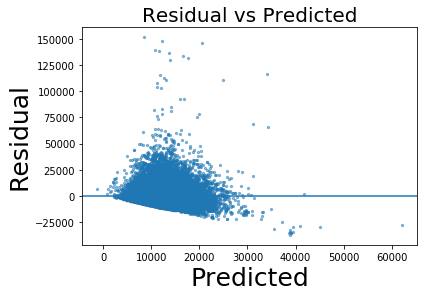

In [12]:
from sklearn import linear_model

lm = linear_model.LinearRegression()
lm.fit(X_train, y_train)

predicted = lm.predict(X_test)
residual = y_test - predicted

plt.scatter(predicted, residual,s=5,alpha=.5)
plt.xlabel('Predicted',fontsize=25)
plt.ylabel('Residual',fontsize=25)
plt.axhline(y=0)
plt.title('Residual vs Predicted',fontsize=20)

In [13]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

rmse = np.sqrt(mean_squared_error(y_test, predicted))

print(rmse)
print(r2_score(y_test, predicted))

9911.145962788198
0.11357263393388417


**KNN**

Text(0.5, 1.0, 'Residual vs Predicted')

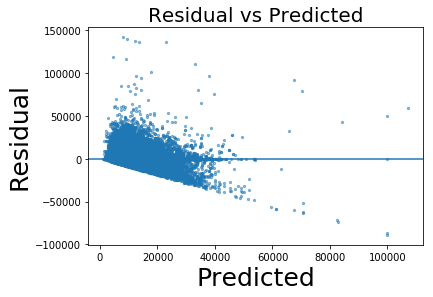

In [17]:
from sklearn import neighbors

knn = neighbors.KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train)

predicted = knn.predict(X_test)
residual = y_test - predicted

plt.scatter(predicted, residual,s=5,alpha=.5)
plt.xlabel('Predicted',fontsize=25)
plt.ylabel('Residual',fontsize=25)
plt.axhline(y=0)
plt.title('Residual vs Predicted',fontsize=20)

In [18]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

rmse = np.sqrt(mean_squared_error(y_test, predicted))

print(rmse)
print(r2_score(y_test, predicted))

9988.00255179067
0.09977161949034286


**Decision Tree**

Text(0.5, 1.0, 'Residual vs Predicted')

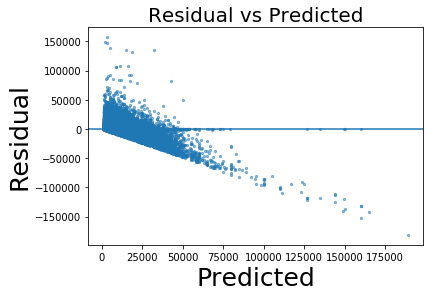

In [22]:
from sklearn.tree import DecisionTreeRegressor

dtr = DecisionTreeRegressor(max_features='auto')
dtr.fit(X_train, y_train)

predicted = dtr.predict(X_test)
residual = y_test - predicted

plt.scatter(predicted, residual,s=5,alpha=.5)
plt.xlabel('Predicted',fontsize=25)
plt.ylabel('Residual',fontsize=25)
plt.axhline(y=0)
plt.title('Residual vs Predicted',fontsize=20)

In [23]:
rmse = np.sqrt(mean_squared_error(y_test, predicted))

print(rmse)
print(r2_score(y_test, predicted))

13043.73655836759
-0.5353219142036665


# Conclusion

So a linear model is the best method we've found to predict the price of a car on craigslist.com when only given the description data. On average the price is off by about 9911 dollars which is not great in the sense that this is almost 1 standard deviation (10,658) on an average price of 11,879. But impressive enough given that we found some signals in text descriptions alone varying from 0 words to 3,256 words.